# Import Packages

This notebook is meant to be run as a one-time way to parse data into a format usable by the new Bitome

In [1]:
from pathlib import Path
import re

from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymodulon.io import load_json_model

# Genes

## COG

In [2]:
cog_table = pd.read_csv('../data/bitome2/mg1655/cogs_ecoli_mg1655.csv')
cog_table.head()

,GI,gene,locus,COG ID,COG category,COG name,COG category primary,COG class,COG description
0,16127996,thrA,b0002,COG0460,E,Homoserine dehydrogenase,E,METABOLISM,Amino acid transport and metabolism
1,16131778,metL,b3940,COG0460,E,Homoserine dehydrogenase,E,METABOLISM,Amino acid transport and metabolism
2,16127996,thrA,b0002,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism
3,16131778,metL,b3940,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism
4,16131850,lysC,b4024,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism


In [3]:
cog_table = cog_table[['locus', 'COG category primary']]
cog_table = cog_table.rename(columns={'locus': 'locus_tag', 'COG category primary': 'cog'})
# some genes have multiple COG, but let's just screw this for now and take the first
cog_table = cog_table.drop_duplicates(subset='locus_tag')

## Essentiality

In [4]:
essential_genes = pd.read_csv('../data/bitome2/mg1655/keio_essentiality_parsed.csv')
essential_genes.head()

,b_number
0,b0025
1,b0027
2,b0029
3,b0031
4,b0048


In [5]:
essential_genes['essential'] = True
essential_genes = essential_genes.rename(columns={'b_number': 'locus_tag'})

## y-ome

In [6]:
yome_table = pd.read_csv('../data/bitome2/mg1655/y-ome-genes.tsv', sep='\t')
yome_table.head()

,locus_id,primary_name,category
0,b0001,thrL,well-annotated
1,b0002,thrA,well-annotated
2,b0003,thrB,well-annotated
3,b0004,thrC,well-annotated
4,b0005,yaaX,y-ome


In [7]:
yome_table = yome_table[['locus_id', 'category']]
yome_table = yome_table.rename(columns={'locus_id': 'locus_tag', 'category': 'y-ome'})

## CIDs

This section uses data read right off of Figure S2 in https://www.sciencedirect.com/science/article/pii/S0092867417315076#figs2: 

Mapping genes/operons to chromosome interacting domain boundaries

Use TSS for forward strand
Use end of gene/operon for reverse


xabc: 50000 (visual estimate; couldn't find this name anywhere else)
yadG: 142779
rrnH: 223485
cyoABDE: 446815
cydDC: 927474
ompF: 985894
fabG: 1080000 (estimated visually; fabG, or accC, appears to be at other end of chromosome in newest annotation?)
icd: 1195008
oppABCDF: 1301085
yddA: 1577657
rplT: 1799393
ydjE: 1852621
IS5: 2102875
fruA: 2259719
elaB: 2380722
ptsH: 2533498
rrnG: 2726069
ygcG: 2905711
IS2: 2996372
yraQ: 3297098
rrnD: 3423423
rpoA: 3440040
IS5: 3652182 
rpmG: 3811250
rrnC: 3941516
rrnA: 4035239
rrnB: 4166484
pyrI: 4470986

In [ ]:
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

## Merge Tables and Save

In [8]:
gene_info_merged = cog_table.merge(essential_genes, how='outer', on='locus_tag').merge(
    yome_table, how='outer', on='locus_tag')
gene_info_merged = gene_info_merged.drop_duplicates()
gene_info_merged.head()

,locus_tag,cog,essential,y-ome
0,b0002,E,NaN,well-annotated
1,b3940,E,NaN,well-annotated
2,b4024,E,NaN,well-annotated
3,b0003,E,NaN,well-annotated
4,b0004,E,NaN,well-annotated


In [9]:
gene_info_merged.to_csv('../data/bitome2/mg1655/gene_info_supp.csv')

# RegulonDB

## Helper Functions

In [10]:
REGULONDB_PATH = Path('../data/bitome2/mg1655/regulondb11.1/')

In [11]:
def read_regulon_db_file(filename) -> pd.DataFrame:
    """
    Given a filename for a raw TXT file from RegulonDB, parses into a DataFrame
    :param Union[str, Path] filename: the filename of the RegulonDB TXT file to read into a pandas DataFrame
    :return pd.DataFrame regulon_df: a pandas DataFrame parsed from a RegulonDB raw TXT file
    """

    full_filename = Path(REGULONDB_PATH, filename)

    with open(full_filename, 'r') as f:
        lines = f.readlines()

    comment = True
    i = 0
    while comment:
        if lines[i].startswith('#') or lines[i].startswith(' #'):
            i += 1
        else:
            comment = False

    names = [line[5:-1].strip() for line in lines if re.match(r'# \d', line)]
    df = pd.read_csv(full_filename, index_col=None, skiprows=i, sep='\t', header=None, names=names)

    return df.drop_duplicates()

In [12]:
def to_strand_int(strand):
    if strand in ['forward', '+', 1, 'FWD']:
        return 1
    elif strand in ['reverse', '-', -1, 'REV']:
        return -1
    else:
        return None

In [13]:
DATA_OUTPUT_PATH = Path('../data/bitome2/mg1655/')

## Operons

In [14]:
operon_df = read_regulon_db_file('operon.txt')
operon_df = operon_df[['OPERON_ID', 'OPERON_NAME', 'REGULATIONPOSLEFT', 'REGULATIONPOSRIGHT', 'OPERON_STRAND']]
operon_df = operon_df.rename(columns={'OPERON_ID': 'locus_tag', 'OPERON_NAME': 'name', 'REGULATIONPOSLEFT': 'left',
                                     'REGULATIONPOSRIGHT': 'right', 'OPERON_STRAND': 'strand'})
operon_df['strand'] = operon_df['strand'].apply(to_strand_int)
operon_df.head()

,locus_tag,name,left,right,strand
0,ECK120007527,ycaM,946936,948659,1.0
1,ECK120011191,rob,4634441,4635382,-1.0
2,ECK120011363,cspE,657096,657549,1.0
3,ECK120011407,treR,4466284,4467347,-1.0
4,ECK120011490,rtcR,3558268,3559866,1.0


In [15]:
operon_df.to_csv(Path(DATA_OUTPUT_PATH, 'operon.csv'))

## Transcription Units, Promoters/TSS, Terminators/TTS

To define the left/right of the TU, we have to get linked information from the promoter (for the TSS end) and from either the terminator (if known) or last gene in the TU to define the other end. 

Start by loading the transcription unit/promoter link information.

In [16]:
tu_df = read_regulon_db_file('transcription_unit.txt')
tu_df = tu_df[['TRANSCRIPTION_UNIT_ID', 'TRANSCRIPTION_UNIT_NAME', 'PROMOTER_ID']]
tu_df = tu_df.rename(columns={'TRANSCRIPTION_UNIT_ID': 'locus_tag', 'TRANSCRIPTION_UNIT_NAME': 'name'})
# drop super annoying reverse box 10 one
tu_df = tu_df[tu_df['name'] != 'fimAICDFGH']
tu_df.head()

,locus_tag,name,PROMOTER_ID
0,ECK120008913,astCADBE,ECK120009851
1,ECK120008914,astCADBE,ECK120009852
2,ECK120008915,astCADBE,ECK120009853
3,ECK120008916,nrdHIEF,ECK120009855
4,ECK120008917,cpxPQ,ECK120010879


NOTE: we can have multiple TUs from the same promoter:

In [17]:
tu_with_prom = tu_df[tu_df['PROMOTER_ID'].notna()]
print(f'{tu_with_prom.shape[0]} TU with promoter')
print(f"{tu_with_prom['PROMOTER_ID'].unique().shape[0]} unique promoters")

2366 TU with promoter
2273 unique promoters


Load the promoter (really a TSS) table:

In [18]:
prom_df = read_regulon_db_file('promoter.txt')
prom_df = prom_df[['PROMOTER_ID', 'PROMOTER_STRAND', 'POS_1', 'SIGMA_FACTOR', 'PROMOTER_NAME']]
prom_df = prom_df.rename(columns={'POS_1': 'tss', 'PROMOTER_STRAND': 'strand', 'PROMOTER_NAME': 'name',
                                 'SIGMA_FACTOR': 'sigma_factor', 'PROMOTER_ID': 'locus_tag'})
prom_df['strand'] = prom_df['strand'].apply(to_strand_int)
prom_df.head()

,locus_tag,strand,tss,sigma_factor,name
0,ECK120009842,1.0,2976569.0,Sigma70,galRp
1,ECK120009843,-1.0,1116709.0,NaN,lpxLp
2,ECK120009844,1.0,1116772.0,NaN,yceAp
3,ECK120009845,1.0,89596.0,Sigma70,mraZp
4,ECK120009846,1.0,1329284.0,Sigma70,sohBp1


Add in the promoter feature information (-10 and -35 boxes)

In [19]:
prom_feat_df = read_regulon_db_file('promoter_feature.txt')
prom_feat_df = prom_feat_df[['PROMOTER_ID', 'BOX_10_LEFT', 'BOX_10_RIGHT', 'BOX_35_LEFT', 'BOX_35_RIGHT']]
prom_feat_df = prom_feat_df.rename(columns={'PROMOTER_ID': 'locus_tag', 'BOX_10_LEFT': 'box_10_left',
                                           'BOX_10_RIGHT': 'box_10_right', 'BOX_35_LEFT': 'box_35_left',
                                           'BOX_35_RIGHT': 'box_35_right'})
prom_df = prom_df.merge(prom_feat_df, how='left', on='locus_tag')
prom_df.head()

,locus_tag,strand,tss,sigma_factor,name,box_10_left,box_10_right,box_35_left,box_35_right
0,ECK120009842,1.0,2976569.0,Sigma70,galRp,2976557.0,2976562.0,2976534.0,2976539.0
1,ECK120009843,-1.0,1116709.0,NaN,lpxLp,NaN,NaN,NaN,NaN
2,ECK120009844,1.0,1116772.0,NaN,yceAp,NaN,NaN,NaN,NaN
3,ECK120009845,1.0,89596.0,Sigma70,mraZp,89588.0,89593.0,89563.0,89568.0
4,ECK120009846,1.0,1329284.0,Sigma70,sohBp1,1329276.0,1329281.0,1329254.0,1329259.0


In [20]:
prom_df.to_csv(Path(DATA_OUTPUT_PATH, 'tss.csv'))

Merge the promoter information with the TU table so we have TSS associated with the TUs

In [22]:
tu_df = tu_df.merge(prom_df.drop(columns='name'), how='left', left_on='PROMOTER_ID', right_on='locus_tag')
tu_df = tu_df.drop(columns=['PROMOTER_ID', 'locus_tag_y'])
tu_df = tu_df.rename(columns={'locus_tag_x': 'locus_tag'})
tu_df.head()

,locus_tag,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right
0,ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0
1,ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0
2,ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0
3,ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0
4,ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0


Load the gene information; we need this to potentially determine where a TU starts/ends

In [23]:
tu_gene_link = read_regulon_db_file('tu_gene_link.txt')
gene_df = read_regulon_db_file('gene.txt')

Load and clean the terminator table; we may use this to define ends of TU, and it's also its own table

In [24]:
terminator_df = read_regulon_db_file('terminator.txt')
terminator_df = terminator_df[['TERMINATOR_ID', 'TERMINATOR_POSLEFT', 'TERMINATOR_POSRIGHT',
                               'TERMINATOR_CLASS']]
terminator_df = terminator_df.rename(columns={'TERMINATOR_POSLEFT': 'left', 'TERMINATOR_POSRIGHT': 'right',
                                              'TERMINATOR_ID': 'locus_tag',
                                              'TERMINATOR_CLASS': 'termination_type'})
terminator_df.head()

,locus_tag,left,right,termination_type
0,ECK120010779,2738912,2738940,rho-independent
1,ECK120010780,2684075,2684093,rho-independent
2,ECK120010781,2311610,2311624,rho-independent
3,ECK120010782,1159325,1159346,rho-independent
4,ECK120010783,1113532,1113560,rho-independent


Use the TU link to get the strand of the terminator

In [25]:
tu_term_link = read_regulon_db_file('tu_terminator_link.txt')
term_df = terminator_df.merge(tu_term_link, how='left', left_on='locus_tag', right_on='TERMINATOR_ID')
term_df = term_df.drop(columns=['TERMINATOR_ID'])
term_df.head()

,locus_tag,left,right,termination_type,TRANSCRIPTION_UNIT_ID
0,ECK120010779,2738912,2738940,rho-independent,ECK120009159
1,ECK120010779,2738912,2738940,rho-independent,ECK120009201
2,ECK120010780,2684075,2684093,rho-independent,ECK120009383
3,ECK120010781,2311610,2311624,rho-independent,ECK120009242
4,ECK120010781,2311610,2311624,rho-independent,ECK120009658


In [26]:
tu_term_link = read_regulon_db_file('tu_terminator_link.txt')
term_df = terminator_df.merge(tu_term_link, how='left', left_on='locus_tag', right_on='TERMINATOR_ID')
term_df = term_df.drop(columns=['TERMINATOR_ID'])
term_df = term_df.merge(tu_df[['locus_tag', 'strand']], how='left',
                        left_on='TRANSCRIPTION_UNIT_ID', right_on='locus_tag')
term_df = term_df.drop(columns=['locus_tag_y', 'TRANSCRIPTION_UNIT_ID'])
term_df = term_df.rename(columns={'locus_tag_x': 'locus_tag'}).drop_duplicates()
term_df

,locus_tag,left,right,termination_type,strand
0,ECK120010779,2738912,2738940,rho-independent,1.0
1,ECK120010779,2738912,2738940,rho-independent,-1.0
2,ECK120010780,2684075,2684093,rho-independent,-1.0
3,ECK120010781,2311610,2311624,rho-independent,-1.0
6,ECK120010782,1159325,1159346,rho-independent,-1.0
...,...,...,...,...,...
631,ECK125296855,4127241,4127262,rho-independent,1.0
633,ECK125296856,2071478,2071511,rho-independent,1.0
634,ECK125296857,787689,787766,rho-dependent,-1.0
636,ECK125296858,787767,787790,rho-independent,-1.0


Terminators can be associated with multiple TUs, and multiple strands; if we have the same terminator locus tag associated with each strand, collapse and just indicate strand as None

In [27]:
term_df_updated = pd.DataFrame(columns=term_df.columns)

idx_counter = 0
for row in term_df.itertuples(index=False):
    already_with_tag = term_df_updated[term_df_updated['locus_tag'] == row.locus_tag]
    if already_with_tag.empty:
        term_df_updated.loc[idx_counter] = row
        idx_counter += 1
    else:
        already_index = already_with_tag.index[0]
        if already_with_tag.loc[already_index, 'strand'] != row.strand:
            term_df_updated.loc[already_index, 'strand'] = None

term_df_updated.head()

,locus_tag,left,right,termination_type,strand
0,ECK120010779,2738912,2738940,rho-independent,NaN
1,ECK120010780,2684075,2684093,rho-independent,-1.0
2,ECK120010781,2311610,2311624,rho-independent,-1.0
3,ECK120010782,1159325,1159346,rho-independent,-1.0
4,ECK120010783,1113532,1113560,rho-independent,1.0


In [28]:
term_df_updated.to_csv(Path(DATA_OUTPUT_PATH, 'terminator.csv'))

Okay, now we have everything we need to define the actual left right of the transcription units:
- if we have a TSS, that is the start. Otherwise, the first gene associated with the tu defines the start. 
- If we have a terminator associated with the tss, the far end of the terminator is the end of the TU. Otherwise, the end of the last gene. 

In [29]:
tu_df.head()

,locus_tag,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right
0,ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0
1,ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0
2,ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0
3,ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0
4,ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0


In [30]:
lefts = []
rights = []
strands = []
for tu_row in tu_df.itertuples(index=False):
    tu_strand = tu_row.strand
    tu_gene_tags = tu_gene_link[tu_gene_link['TRANSCRIPTION_UNIT_ID'] == tu_row.locus_tag]['GENE_ID']
    tu_gene_df = gene_df[gene_df['GENE_ID'].isin(tu_gene_tags)]
    gene_left, gene_right = min(tu_gene_df['GENE_POSLEFT']), max(tu_gene_df['GENE_POSRIGHT'])
    tu_term_tags = tu_term_link[tu_term_link['TRANSCRIPTION_UNIT_ID'] == tu_row.locus_tag]['TERMINATOR_ID']
    tu_term_df = term_df_updated[term_df_updated['locus_tag'].isin(tu_term_tags)]
    if not tu_term_df.empty:
        term_left, term_right = min(tu_term_df['left']), max(tu_term_df['right'])
    else:
        term_left = term_right = None
    # some of the TU strands are unknown
    if pd.isna(tu_strand) and not tu_gene_df.empty:
        tu_strand = to_strand_int(tu_gene_df['GENE_STRAND'].unique()[0])
    strands.append(tu_strand)
    if tu_strand == 1:
        if pd.isna(tu_row.tss):
            tu_left = gene_left
        else:
            tu_left = tu_row.tss
        if term_right is None:
            tu_right = gene_right
        else:
            tu_right = term_right
    elif tu_strand == -1:
        if pd.isna(tu_row.tss):
            tu_right = gene_right
        else:
            tu_right = tu_row.tss
        if term_left is None:
            tu_left = gene_left
        else:
            tu_left = term_left
    else:
        tu_left = tu_right = None
    lefts.append(tu_left)
    rights.append(tu_right)


tu_df['left'] = lefts
tu_df['right'] = rights
tu_df['strand'] = strands

tu_df = tu_df[(tu_df['left'].notna()) & (tu_df['right'].notna())]

### TODO don't drop duplicates naively

In [31]:
tu_df = tu_df.drop_duplicates(subset=['locus_tag', 'tss'])

In [32]:
# TODO don't drop duplicates naively
tu_df.to_csv(Path(DATA_OUTPUT_PATH, 'tu.csv'))

Now we can load some more standalone features; attenuator, Shine-Dalgarno, riboswitches

## Attenuator

In [33]:
attenuator_df = read_regulon_db_file('attenuator.txt')
attenuator_df = attenuator_df[['ATTENUATOR_ID', 'ATTENUATOR_TYPE', 'ATTENUATOR_STRAND']]
attenuator_df = attenuator_df.rename(columns={'ATTENUATOR_ID': 'locus_tag', 'ATTENUATOR_TYPE': 'attenuator_type',
                                     'ATTENUATOR_STRAND': 'strand'})
attenuator_df['strand'] = attenuator_df['strand'].apply(to_strand_int)
attenuator_df.head()

,locus_tag,attenuator_type,strand
0,ECK125143526,Transcriptional,1
1,ECK125143530,Transcriptional,1
2,ECK125143534,Translational,1
3,ECK125143536,Transcriptional,-1
4,ECK125143540,Transcriptional,1


An attenuator is a complex of RNA secondary structure with multiple overlapping stem-loops that prevents procession of
the RNA polymerase or ribosome (transcriptional vs translational attenuation). We can define the bounds of the 
attenuator as the widest ends of the stem-loop sub-pieces

In [34]:
atten_term_df = read_regulon_db_file('attenuator_terminator.txt')
atten_term_df.head()

,A_TERMINATOR_ID,A_TERMINATOR_TYPE,A_TERMINATOR_POSLEFT,A_TERMINATOR_POSRIGHT,A_TERMINATOR_ENERGY,A_TERMINATOR_SEQUENCE,A_TERMINATOR_ATTENUATOR_ID
0,ECK125143527,terminator,276,311,-20.00,aacacagaaaAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCg...,ECK125143526
1,ECK125143528,anti-terminator,244,288,-19.41,acaggtaacgGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAG...,ECK125143526
2,ECK125143529,anti-anti-terminator,200,255,-14.50,tgaaacgcatTAGCACCACCATTACCACCACCATCACCATTACCAC...,ECK125143526
3,ECK125143531,terminator,5042,5078,-19.30,atctcaatcaGGCCGGGTTTGCTTTTATGCAGCCCGGCTTTTTTAT...,ECK125143530
4,ECK125143532,anti-terminator,4979,5051,-11.90,ctgcccgccgATTTTGCTGCGTTGCGTAAATTGATGATGAATCATC...,ECK125143530


In [35]:
lefts = []
rights = []

for att_row in attenuator_df.itertuples(index=False):
    a_term_df = atten_term_df[atten_term_df['A_TERMINATOR_ATTENUATOR_ID'] == att_row.locus_tag]
    a_term_left, a_term_right = min(a_term_df['A_TERMINATOR_POSLEFT']), max(a_term_df['A_TERMINATOR_POSRIGHT'])
    lefts.append(a_term_left)
    rights.append(a_term_right)

attenuator_df['left'] = lefts
attenuator_df['right'] = rights
attenuator_df.head()

,locus_tag,attenuator_type,strand,left,right
0,ECK125143526,Transcriptional,1,200,311
1,ECK125143530,Transcriptional,1,4979,5078
2,ECK125143534,Translational,1,14134,14155
3,ECK125143536,Transcriptional,-1,21166,21255
4,ECK125143540,Transcriptional,1,20912,20982


In [36]:
attenuator_df.to_csv(Path(DATA_OUTPUT_PATH, 'attenuator.csv'))

## RBS

In [37]:
rbs_df = read_regulon_db_file('shine_dalgarno.txt')
rbs_df = rbs_df[['SHINE_DALGARNO_ID', 'SHINE_DALGARNO_POSLEFT', 'SHINE_DALGARNO_POSRIGHT', 'GENE_ID']]
rbs_df = rbs_df.rename(columns={'SHINE_DALGARNO_ID': 'locus_tag', 'SHINE_DALGARNO_POSLEFT': 'left',
                                     'SHINE_DALGARNO_POSRIGHT': 'right'})
rbs_df.head()

,locus_tag,left,right,GENE_ID
0,ECK120014181,3151252,3151257,ECK120000266
1,ECK120014182,3151991,3151996,ECK120000265
2,ECK120014183,3957829,3957834,ECK120000496
3,ECK120014184,3957957,3957962,ECK120000488
4,ECK120014185,3469859,3469864,ECK120001215


Use the gene lookup to get strand

In [38]:
strands = []

for rbs_row in rbs_df.itertuples(index=False):
    strands.append(gene_df[gene_df['GENE_ID'] == rbs_row.GENE_ID].iloc[0, :]['GENE_STRAND'])
    
rbs_df['strand'] = pd.Series(strands).apply(to_strand_int)
rbs_df.head()

,locus_tag,left,right,GENE_ID,strand
0,ECK120014181,3151252,3151257,ECK120000266,-1
1,ECK120014182,3151991,3151996,ECK120000265,-1
2,ECK120014183,3957829,3957834,ECK120000496,-1
3,ECK120014184,3957957,3957962,ECK120000488,1
4,ECK120014185,3469859,3469864,ECK120001215,-1


In [39]:
rbs_df.to_csv(Path(DATA_OUTPUT_PATH, 'rbs.csv'))

## Riboswitch

In [40]:
riboswitch_df = read_regulon_db_file('rfam.txt')
riboswitch_df = riboswitch_df[['RFAM_ID', 'RFAM_STRAND', 'RFAM_POSLEFT', 'RFAM_POSRIGHT']]
riboswitch_df = riboswitch_df.rename(columns={'RFAM_ID': 'locus_tag', 'RFAM_POSLEFT': 'left',
                                     'RFAM_POSRIGHT': 'right', 'RFAM_STRAND': 'strand'})
riboswitch_df['strand'] = riboswitch_df['strand'].apply(to_strand_int)
riboswitch_df.head()

,locus_tag,strand,left,right
0,ECK125145739,-1,75511,75610
1,ECK125230739,-1,1144392,1144728
2,ECK125230740,1,493356,493420
3,ECK125230741,1,780561,780729
4,ECK125230742,1,780850,781016


In [41]:
riboswitch_df.to_csv(Path(DATA_OUTPUT_PATH, 'riboswitch.csv'))

## TFBS

Need to parse a lot of different stuff to get this right

In [87]:
# have to do some cleanup on the newest version of the TF file
with open(Path(REGULONDB_PATH, 'transcription_factor.txt'), 'r') as tf_file:
    lines = tf_file.readlines()
    lines = [l for l in lines if l[0] != '#' and l[:2] != ' #']
    lines = [l for l in lines if l != '\n']
    lines = [l for l in lines if l[:3] == 'ECK']
    lines_split = [l.split('\t')[:2] for l in lines]
    tf_ids, tf_names = zip(*lines_split)
    
tf_df = pd.DataFrame(data={
    'TRANSCRIPTION_FACTOR_ID': tf_ids,
    'TRANSCRIPTION_FACTOR_NAME': tf_names
})
tf_df.head()

,TRANSCRIPTION_FACTOR_ID,TRANSCRIPTION_FACTOR_NAME
0,ECK120011186,Fis
1,ECK120011190,Rob
2,ECK120011194,TyrR
3,ECK120011202,ArgP
4,ECK120011210,CpxR


In [88]:
reg_interaction_df = read_regulon_db_file('regulatory_interaction.txt')
reg_interaction_df = reg_interaction_df[['SITE_ID', 'RI_FUNCTION', 'CONFORMATION_ID']]
reg_interaction_df.head()

,SITE_ID,RI_FUNCTION,CONFORMATION_ID
0,ECK120012046,activator,ECK125269234
1,ECK120012328,activator,ECK125269282
2,ECK120012328,repressor,ECK125269395
3,ECK120012328,activator,ECK125269282
4,ECK120012328,repressor,ECK125269395


In [89]:
tfbs_df = read_regulon_db_file('site.txt')
tfbs_df = tfbs_df[['SITE_ID', 'SITE_POSLEFT', 'SITE_POSRIGHT']]
tfbs_df.head()

,SITE_ID,SITE_POSLEFT,SITE_POSRIGHT
0,ECK120011181,612650.0,612668
1,ECK120011184,4516744.0,4516762
2,ECK120011188,1619005.0,1619019
3,ECK120011192,1619022.0,1619041
4,ECK120011197,3305958.0,3305975


In [90]:
tf_conf_df = read_regulon_db_file('conformation.txt')
tf_conf_df = tf_conf_df[['CONFORMATION_ID', 'TRANSCRIPTION_FACTOR_ID', 'FINAL_STATE']]
tf_conf_df.head()

,CONFORMATION_ID,TRANSCRIPTION_FACTOR_ID,FINAL_STATE
0,ECK120012025,ECK125302599,ZntR
1,ECK125109071,ECK125286588,DcuR
2,ECK125109092,ECK125286591,KdpE
3,ECK125109133,ECK125286592,UhpA
4,ECK125146590,ECK125288994,CueR-Ag


Do some merging to get these into the state we want

In [91]:
tfbs_df = tfbs_df.merge(reg_interaction_df, how='left', on='SITE_ID')
tfbs_df = tfbs_df.merge(tf_conf_df, how='left', on='CONFORMATION_ID')
tfbs_df = tfbs_df.merge(tf_df, how='left', on='TRANSCRIPTION_FACTOR_ID')
tfbs_df.head()

,SITE_ID,SITE_POSLEFT,SITE_POSRIGHT,RI_FUNCTION,CONFORMATION_ID,TRANSCRIPTION_FACTOR_ID,FINAL_STATE,TRANSCRIPTION_FACTOR_NAME
0,ECK120011181,612650.0,612668,repressor,ECK125269238,ECK125285350,Fur-Fe<sup>2+</sup>,Fur
1,ECK120011181,612650.0,612668,repressor,ECK125269238,ECK125285350,Fur-Fe<sup>2+</sup>,Fur
2,ECK120011184,4516744.0,4516762,repressor,ECK125269238,ECK125285350,Fur-Fe<sup>2+</sup>,Fur
3,ECK120011188,1619005.0,1619019,activator,ECK125269242,ECK120011186,Fis,Fis
4,ECK120011192,1619022.0,1619041,activator,ECK125269239,ECK120011190,Rob,Rob


In [92]:
tfbs_df = tfbs_df.drop(columns=['CONFORMATION_ID', 'TRANSCRIPTION_FACTOR_ID'])
tfbs_df = tfbs_df.rename(columns={'SITE_ID': 'locus_tag', 'SITE_POSLEFT': 'left', 'SITE_POSRIGHT': 'right',
                                 'RI_FUNCTION': 'mode', 'FINAL_STATE': 'final_state',
                                 'TRANSCRIPTION_FACTOR_NAME': 'tf'})
tfbs_df['strand'] = None
tfbs_df.head()

,locus_tag,left,right,mode,final_state,tf,strand
0,ECK120011181,612650.0,612668,repressor,Fur-Fe<sup>2+</sup>,Fur,None
1,ECK120011181,612650.0,612668,repressor,Fur-Fe<sup>2+</sup>,Fur,None
2,ECK120011184,4516744.0,4516762,repressor,Fur-Fe<sup>2+</sup>,Fur,None
3,ECK120011188,1619005.0,1619019,activator,Fis,Fis,None
4,ECK120011192,1619022.0,1619041,activator,Rob,Rob,None


In [93]:
tfbs_df.to_csv(Path(DATA_OUTPUT_PATH, 'tfbs.csv'))

# BK Cho TU Architecture (Nature Biotech 2009)

In [49]:
cho_tu_df = pd.read_csv(Path('../data/bitome2/mg1655/tu_architecture_cho.csv'))
cho_tu_df.head()

,TU,Strand,Start,End,Len,MU Assembly,TSS,Current Annotation Assembly,Promoter,Start.1,5'UTR Len
0,TU-0001,FWD,150,5000,4850,MU-1;MU-2,148.0,thrL;thrA;thrB;thrC,thrL,190.0,42.0
1,TU-0002,FWD,150,5000,4850,MU-1;MU-2,163.0,thrL;thrA;thrB;thrC,thrL,190.0,27.0
2,TU-0003,FWD,150,5000,4850,MU-1;MU-2,170.0,thrL;thrA;thrB;thrC,thrL,190.0,20.0
3,TU-0004,FWD,2600,5000,2400,MU-2,2688.0,thrB;thrC,thrB,2801.0,113.0
4,TU-0005,FWD,5050,5525,475,MU-3,5118.0,yaaX,yaaX,5234.0,116.0


In [50]:
cho_tss_df = pd.read_csv(Path('../data/bitome2/mg1655/tss_reads_cho_s4.csv'))
cho_tss_df.head()

,tss_id,strand,tss,reads_log,reads_hs,reads_hs_stat,rts_id
0,TSS-FWD-1,FWD,148,3459.0,3502.0,3522,RTS_R4_+_1
1,TSS-FWD-2,FWD,163,774.0,774.0,774,RTS_R4_+_1
2,TSS-FWD-3,FWD,170,734.0,735.0,736,RTS_R4_+_1
3,TSS-FWD-4,FWD,2688,72.0,72.0,72,RTS_R4_+_2
4,TSS-FWD-5,FWD,5118,3.0,3.0,3,RTS_R4_+_3


In [51]:
cho_tu_tss_df = cho_tu_df.merge(cho_tss_df, left_on='TSS ', right_on='tss', how='outer')
cho_tu_tss_df = cho_tu_tss_df.drop(columns=['MU Assembly', 'strand', 'TSS ', 'rts_id'])
cho_tu_tss_df.head()

,TU,Strand,Start,End,Len,Current Annotation Assembly,Promoter,Start.1,5'UTR Len,tss_id,tss,reads_log,reads_hs,reads_hs_stat
0,TU-0001,FWD,150,5000,4850,thrL;thrA;thrB;thrC,thrL,190.0,42.0,TSS-FWD-1,148.0,3459.0,3502.0,3522.0
1,TU-0002,FWD,150,5000,4850,thrL;thrA;thrB;thrC,thrL,190.0,27.0,TSS-FWD-2,163.0,774.0,774.0,774.0
2,TU-0003,FWD,150,5000,4850,thrL;thrA;thrB;thrC,thrL,190.0,20.0,TSS-FWD-3,170.0,734.0,735.0,736.0
3,TU-0004,FWD,2600,5000,2400,thrB;thrC,thrB,2801.0,113.0,TSS-FWD-4,2688.0,72.0,72.0,72.0
4,TU-0005,FWD,5050,5525,475,yaaX,yaaX,5234.0,116.0,TSS-FWD-5,5118.0,3.0,3.0,3.0


## Comparison to RegulonDB

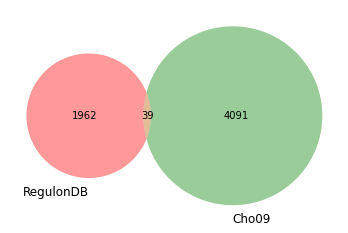

In [81]:
regulon_tsses = list(tu_df['tss'].dropna().unique())
cho_tsses = list(cho_tu_tss_df['tss'].dropna().unique())

venn2([set(regulon_tsses), set(cho_tsses)], set_labels=['RegulonDB', 'Cho09'])

What's the typical offset between the closest pairs of TSS in each dataset?

Text(0, 0.5, 'Count')

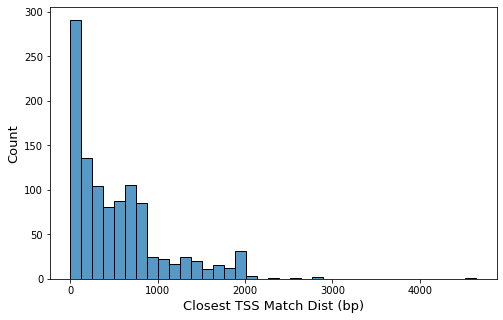

In [91]:
reg_tss_closests = {}

for reg_tss in regulon_tsses:
    closest_cho = np.array(cho_tsses)[np.argmin(np.abs(np.array(cho_tsses) - reg_tss))]
    reg_tss_closests[reg_tss] = closest_cho

cho_tss_closets = {}
for cho_tss in cho_tsses:
    closest_reg = np.array(regulon_tsses)[np.argmin(np.abs(np.array(regulon_tsses) - cho_tss))]
    cho_tss_closets[cho_tss] = closest_reg
    
bi_best_hit_pairs = []

for reg_tss, cho_tss_closest in reg_tss_closests.items():
    reg_tss_for_cho = cho_tss_closets[cho_tss_closest]
    if reg_tss_for_cho == reg_tss:
        bi_best_hit_pairs.append((reg_tss, cho_tss_closest))
        
best_hit_dists = [abs(tup[0] - tup[1]) for tup in bi_best_hit_pairs]

_, ax = plt.subplots(figsize=(8, 5))

sns.histplot(best_hit_dists, ax=ax)
ax.set_xlabel('Closest TSS Match Dist (bp)', fontsize=13)
ax.set_ylabel('Count', fontsize=13)

# RegulonDB TSS Supplement

In [98]:
tss_reads_df = read_regulon_db_file(
    'Promoter_from_454_Dataset.txt'
)
tss_reads_df.columns = ['left', 'right', 'cluster_center', 'tss_len', 'n_reads', 'strand', 'gene_name',
                       'b_num', 'gene_left', 'gene_right', 'gene_rel_orient']
# get rid of cluster TSS, not clear what these are
tss_reads_df = tss_reads_df[tss_reads_df['tss_len'] == 1]
tss_reads_df

,left,right,cluster_center,tss_len,n_reads,strand,gene_name,b_num,gene_left,gene_right,gene_rel_orient
0,2310676,2310676,2310676,1,3092254,forward,ompC,b2215,2309668.0,2310771.0,InAntiSense
5,2547957,2547957,2547957,1,620711,forward,yfeX,b2431,2547668.0,2548567.0,InAntiSense
8,3438278,3438278,3438278,1,381216,forward,rpoA,b3295,3438062.0,3439051.0,InAntiSense
10,2735403,2735403,2735403,1,309057,forward,raiA,b2597,2735176.0,2735517.0,InSense
22,3886434,3886434,3886434,1,149916,forward,tnaC,b3707,3886458.0,3886532.0,UpSense
...,...,...,...,...,...,...,...,...,...,...,...
5192,709696,709696,709696,1,65,reverse,fur,b0683,709423.0,709869.0,InSense
5193,2639955,2639955,2639955,1,60,reverse,ispG,b2515,2638708.0,2639826.0,UpSense
5194,1249116,1249116,1249116,1,53,reverse,dhaL,b1199,1248348.0,1248980.0,UpSense
5195,3720573,3720573,3720573,1,41,reverse,glyS,b3559,3720351.0,3722420.0,InSense


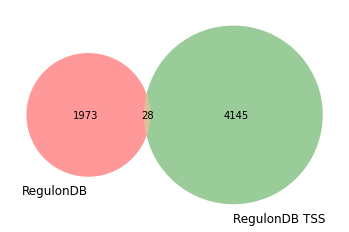

In [99]:
extra_tsses = list(tss_reads_df['cluster_center'].dropna().unique())

venn2([set(regulon_tsses), set(extra_tsses)], set_labels=['RegulonDB', 'RegulonDB TSS'])